In [1]:
import torchaudio
from src.STFT import ipcSTFT
import matplotlib.pyplot as plt
import torch

stft = ipcSTFT(
    n_fft=512,
    hop_length=128,
    win_length=512
)
def plot_complex_spectrogram(spectrogram, vmax, vmin, axes=None):
    assert len(axes) == 2, "axes must be a list of 2 axes"
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(6, 6))
    if vmax is None:
        vmax = (torch.quantile(spectrogram.real, 0.95), torch.quantile(spectrogram.imag, 0.95))
    if vmin is None:
        vmin = (torch.quantile(spectrogram.real, 0.05), torch.quantile(spectrogram.imag, 0.05))
    axes[0].pcolormesh(spectrogram.real.detach().cpu().numpy(), vmax=vmax[0], vmin=vmin[0])
    axes[0].set_title("Real part")
    axes[1].pcolormesh(spectrogram.imag.detach().cpu().numpy(), vmax=vmax[1], vmin=vmin[1])
    axes[1].set_title("Imaginary part")
    return axes, vmax, vmin

def plot_abslog_spectrogram(spectorgram):
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    ax.pcolormesh(20*torch.log10(spectorgram.abs()).detach().cpu().numpy())
    ax.set_title("Log-magnitude")
    plt.show()

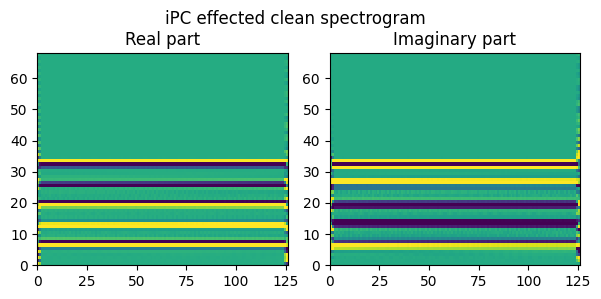

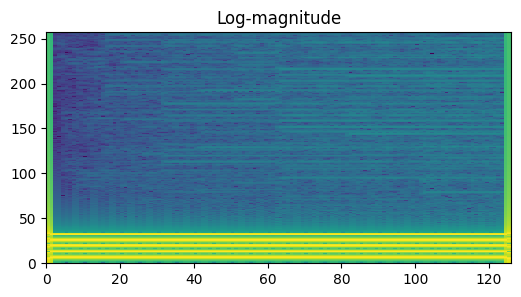

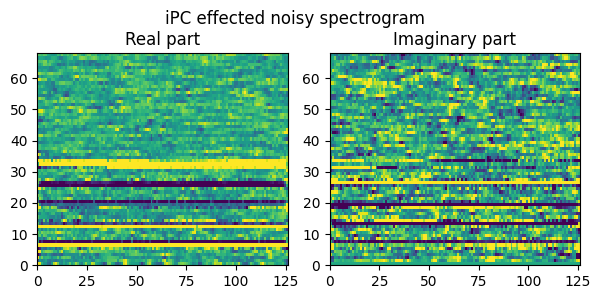

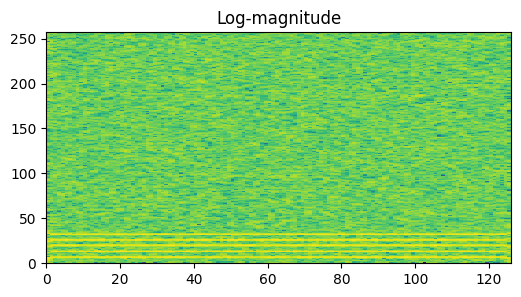

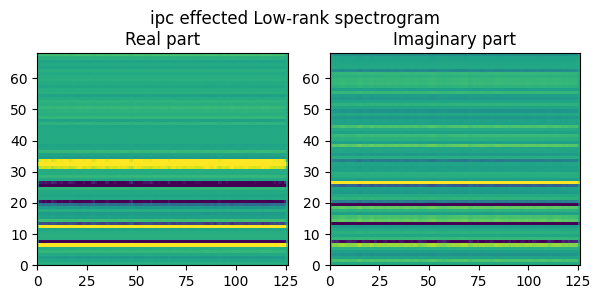

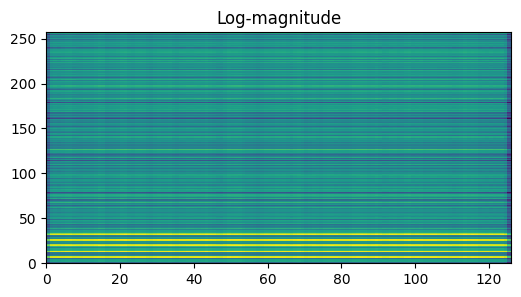

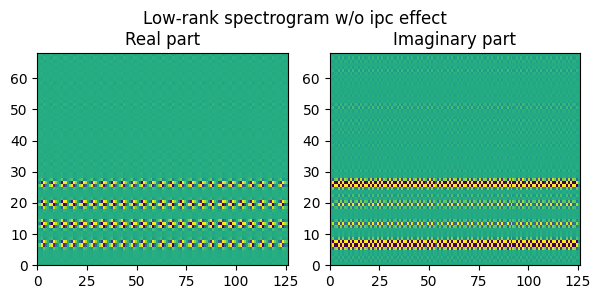

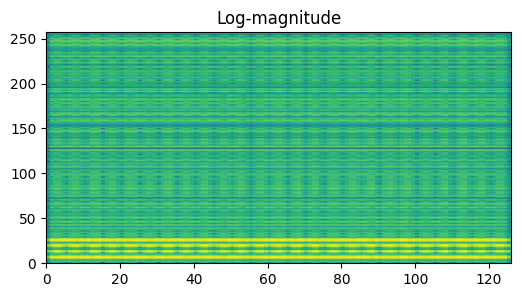

In [2]:
import IPython.display as ipd

sample_rate = 16000
t = torch.linspace(0, 1, sample_rate)
waveform = torch.sin(2 * torch.pi * 200 * t) + \
              torch.sin(2 * torch.pi * 400 * t) + \
              torch.sin(2 * torch.pi * 600 * t) + \
              torch.sin(2 * torch.pi * 800 * t) + \
              torch.sin(2 * torch.pi * 1000 * t)
waveform = waveform.unsqueeze(0)

sample_rate = 16000
t = torch.linspace(0, 1, sample_rate)
waveform = torch.sin(2 * torch.pi * 200 * t) + \
              torch.sin(2 * torch.pi * 400 * t) + \
              torch.sin(2 * torch.pi * 600 * t) + \
              torch.sin(2 * torch.pi * 800 * t) + \
              torch.sin(2 * torch.pi * 1000 * t)
waveform = waveform.unsqueeze(0)

# ipc stft
ipd.display(ipd.Audio(waveform.squeeze().numpy(), rate=sample_rate))
spec, inv_ope = stft.stft(waveform)
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
_, vmax, vmin = plot_complex_spectrogram(spec[0,:68], None, None, axes)
fig.tight_layout(rect=[0,0,1,0.96])
fig.suptitle("iPC effected clean spectrogram")
plt.show()
plot_abslog_spectrogram(spec[0])

noise = torch.randn_like(waveform)

waveform = torchaudio.functional.add_noise(waveform, noise, snr=torch.tensor([0]))

# ipc stft
ipd.display(ipd.Audio(waveform.squeeze().numpy(), rate=sample_rate))
spec, inv_ope = stft.stft(waveform)
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
plot_complex_spectrogram(spec[0,:68], vmax, vmin, axes)
fig.tight_layout(rect=[0,0,1,0.96])
fig.suptitle("iPC effected noisy spectrogram")
plt.show()
plot_abslog_spectrogram(spec[0])

import numpy as np
from sklearn.decomposition import TruncatedSVD

def low_rank_approximation(X):
    svd = TruncatedSVD(n_components=1, n_iter=30)
    svd.fit(X)
    X_approx = svd.inverse_transform(svd.transform(X))
    return X_approx

X_npr, X_npi = spec[0].real.numpy(), spec[0].imag.numpy()
X_approx_r, X_approx_i = low_rank_approximation(X_npr), low_rank_approximation(X_npi)
X_approx_r, X_approx_i = torch.tensor(X_approx_r), torch.tensor(X_approx_i)
X_approx = X_approx_r + 1j * X_approx_i
X_approx = X_approx.unsqueeze(0)
x_approx = stft.istft(X_approx, inv_ope)
ipd.display(ipd.Audio(x_approx.squeeze().numpy(), rate=sample_rate))
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
plot_complex_spectrogram(X_approx[0,:68], vmax, vmin, axes)
fig.tight_layout(rect=[0,0,1,0.96])
fig.suptitle("ipc effected Low-rank spectrogram")
plt.show()
plot_abslog_spectrogram(X_approx[0])

# w/o ipc and low-rank modeling
spec_ = spec*inv_ope
X_npr, X_npi = spec_[0].real.numpy(), spec_[0].imag.numpy()
X_approx_r, X_approx_i = low_rank_approximation(X_npr), low_rank_approximation(X_npi)
X_approx_r, X_approx_i = torch.tensor(X_approx_r), torch.tensor(X_approx_i)
X_approx = X_approx_r + 1j * X_approx_i
X_approx = X_approx.unsqueeze(0)
x_approx = stft.istft(X_approx)
ipd.display(ipd.Audio(x_approx.squeeze().numpy(), rate=sample_rate))
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
plot_complex_spectrogram(X_approx[0,:68], vmax, vmin, axes)
fig.tight_layout(rect=[0,0,1,0.96])
fig.suptitle("Low-rank spectrogram w/o ipc effect")
plt.show()
plot_abslog_spectrogram(X_approx[0])